# Clustering Using Pairwise Comparison

Clustering GP bitmaps

## Application to Preference Shopping

According to the work of R. Srikant, it is possible to cluster users based on incomplete information on their purchasing preferences. They achieve this by converting an (Mx2) matrix about the choices of users over products into an (M) 'net wins matrix'.

For instance assume we have 4 products (r1, r2, r3, r4) and 3 users (u1, u2, u3). We use the following encoding: if a user picks r1 over r2 (r1 > r2) then (r1,r2)=1 and (r2,r1)=-1; if we do not have a preferred choice (this accounts for incomplete information) between r3 and r4 then the encoding is (r3,r4)=0.

A sample matrix may take the form:

| u |(r1,r2) | (r1,r3) | (r1,r4) | (r2,r3) | (r2,r4) | (r3,r4) |
| :--- | :---: | :---: | :---: | :---: | :---: | :---: |
| u1 | 1 | 0 | 0 | -1 | 1 | 0 |
| u2 | 0 | 1 | 0 | -1 | 0 | 0 |
| u3 | 1 | -1 | 0 | 0 | 1 | 0 |


Using the available preference information, we can convert this matric into a 'net wins matrix' as shown below (i.e., for each item if it has more wins than losses then it is 1; if it has more losses than wins then it is -1; if the losses and equal to wins then it is 0; if it has no information then it is 0)

| u | r1 | r2 | r3 | r4 |
| --- | --- | --- | --- | --- |
| u1 | 1 | -1 | 1 | -1 |
| u2 | 1 | -1 | 0 | 0 |
| u3 | 0 | 0 | 1 | -1 |

We can use this new matrix to cluster users based on their purchase preferences using spectral clustering.

## Application to GP Mining

In order to mine for GPs, each feature has to construct a bitmap matrix comparing each row to each other (i.e., (r1,r2), (r1,r3), (r1,r4), (r2,r3), (r2,r4), (r3,r4)).

We can apply the same approach here, such that, we only construct the bitmap matrix with a handful of rows then convert them into 'net wins matrices'. Finally, we apply spectral clustering to determine which features belong to the same group based on the similarity of gradual dependency.

# Install Libraries

In [1]:
# Installing Libraries (if not installed)
#!pip3 install jupyterlab-git
#!pip3 install voila
#!pip3 install matplotlib
#!pip3 install scikit-learn
#!pip3 install seaborn
#!pip3 install numpy
#!pip3 install pandas
#!pip3 install so4gp
#!pip3 install scipy
#!pip3 install sympy
#!pip3 install networkx

# Import libraries <a name="lib-import"></a>

In [69]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt

from numpy.linalg import svd
from sklearn.cluster import KMeans


In [55]:
import so4gp as sgp

# Data set
Retrieving data set and the features

In [203]:
ds = sgp.DataGP('../data/DATASET.csv')
#ds = sgp.DataGP('../data/c2k_02k.csv')
#ds = sgp.DataGP('../data/breast_cancer.csv')


data_size = ds.row_count
feature_size = ds.col_count
features = np.array(ds.data, dtype=np.float64)
features

array([[30.,  3.,  1., 10.,  2.,  4.],
       [35.,  2.,  2.,  8.,  2.,  4.],
       [40.,  4.,  2.,  7.,  2.,  4.],
       [50.,  1.,  1.,  6.,  2.,  4.],
       [52.,  7.,  1.,  2.,  2.,  4.]])

In [187]:
# Mine GPs using existing GRAANK algorithm
#sgp.graank('../data/breast_cancer.csv', min_sup=0.6)

# Clustering GPs using Gradual Pairs

## a. Constructing Pair Matrix
We construct gradual pairs using the following encoding:

if r1 > r2, then (r1,r2) = 1

if r1 < r2 then (r1,r2) = -1

if r1 == r2 then (r1,r2) = 0


In [188]:
# Function for constructing GP pairs for Mx2 matrix

def construct_pairs():
    X = []
    for i in range(data_size):
        for j in range(i+1, data_size):
            x = []
            for k in range(feature_size):
                if features[j][k] > features[i][k]:
                    encoding = 1
                elif features[j][k] < features[i][k]:
                    encoding = -1
                else:
                    encoding = 0
                x.append(encoding)
            X.append(x)
    return np.array(X, dtype=float).T

def construct_bm_pairs():
    attr_data = features.T
    bm_data = []
    for c_data in attr_data:
        col_data = np.array(c_data, dtype=float)
        pair_bitmap = np.where(col_data > col_data[:, np.newaxis], 1, np.where(col_data < col_data[:, np.newaxis], -1, 0))
        bm_data.append(pair_bitmap)
    return bm_data

In [191]:
M = construct_pairs()
print(M)

Mp = construct_bm_pairs()
Mp

[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [-1.  1. -1.  1.  1. -1.  1. -1.  1.  1.]
 [ 1.  1.  0.  0.  0. -1. -1. -1. -1.  0.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


[array([[ 0,  1,  1,  1,  1],
        [-1,  0,  1,  1,  1],
        [-1, -1,  0,  1,  1],
        [-1, -1, -1,  0,  1],
        [-1, -1, -1, -1,  0]]),
 array([[ 0, -1,  1, -1,  1],
        [ 1,  0,  1, -1,  1],
        [-1, -1,  0, -1,  1],
        [ 1,  1,  1,  0,  1],
        [-1, -1, -1, -1,  0]]),
 array([[ 0,  1,  1,  0,  0],
        [-1,  0,  0, -1, -1],
        [-1,  0,  0, -1, -1],
        [ 0,  1,  1,  0,  0],
        [ 0,  1,  1,  0,  0]]),
 array([[ 0, -1, -1, -1, -1],
        [ 1,  0, -1, -1, -1],
        [ 1,  1,  0, -1, -1],
        [ 1,  1,  1,  0, -1],
        [ 1,  1,  1,  1,  0]]),
 array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]),
 array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]])]

## b. Bulding the Net Wins Matrix

We construct a Net Wins matrix as follows

In [297]:
def construct_net_wins(M):
    N = []
    for bm in M:
        R = []
        Rinv = []
        for r in bm:
            s = np.sum(r)
            if s > 0:
                s = 1
            elif s < 0:
                s = -1
            R.append(s)
            Rinv.append(-s)
        N.append(R)
        N.append(Rinv)
        #print(R)
        #print(Rinv)
        #print("\n")
    return np.array(N)

In [299]:
N = construct_net_wins(Mp)
N = N[0:8]
N

array([[ 1,  1,  0, -1, -1],
       [-1, -1,  0,  1,  1],
       [ 0,  1, -1,  1, -1],
       [ 0, -1,  1, -1,  1],
       [ 1, -1, -1,  1,  1],
       [-1,  1,  1, -1, -1],
       [-1, -1,  0,  1,  1],
       [ 1,  1,  0, -1, -1]])

## c. Compute Singular Value Decomposition values

[4.46131379e+00 2.92374412e+00 2.35550410e+00 2.20543323e-16
 2.07785271e-17]


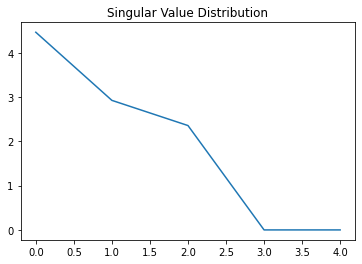

In [300]:
# Perform single value distribution to determine the independent rows
U, S, VT = svd(N)
Sd = np.diag(S)
print(S)

plt.figure(1)
plt.plot(S)
plt.title('Singular Value Distribution')
plt.show()

In [301]:
# Select the r independent rows
Sr = S.copy()
r = 3
for index, value in enumerate(Sr):
    if index >= r:
        Sr[index] = 0
        pass

# Retain only r singular values and set the rest equal to zero
Sr = np.diag(Sr)
Sr

array([[4.46131379, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 2.92374412, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 2.3555041 , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

## d. Spectral Clustering

Cluster the rows of the rank r projection using K-Means algorithm


In [304]:
kmeans = KMeans(n_clusters=4, random_state=0)
y_pred = kmeans.fit_predict(N)
y_pred

array([1, 0, 2, 3, 0, 1, 0, 1], dtype=int32)

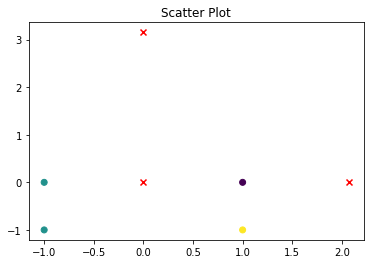

In [253]:

plt.figure(1)
plt.scatter(N[:,1], N[:,2], c=y_pred)
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 0], c='red', marker='x')
plt.title('Scatter Plot')
plt.show()